<a href="https://colab.research.google.com/github/Harry1226/Arduino_project/blob/main/TinyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.0.0-rc1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-rc1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.0.0-rc1


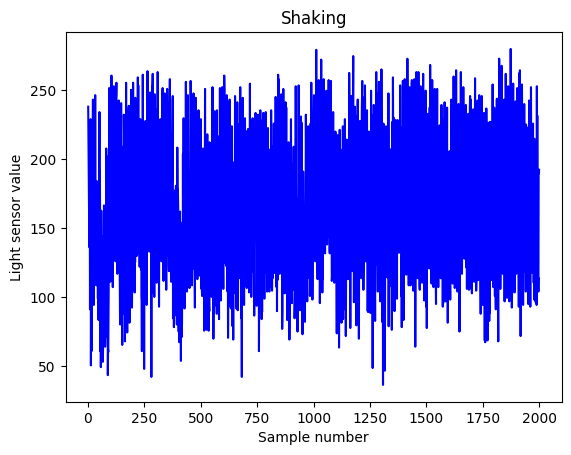

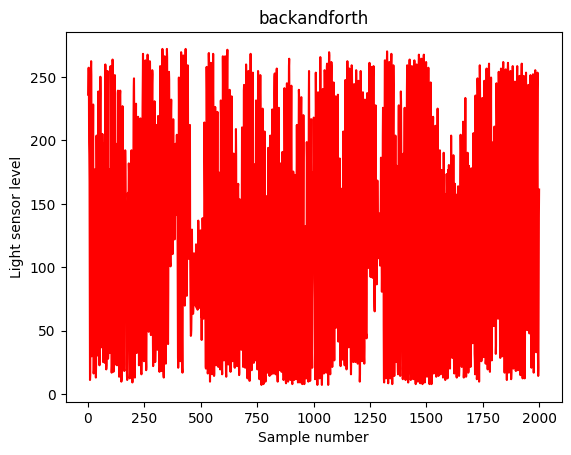

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename1 = "shaking.csv"
filename2 = "backandforth.csv"
filename3 = "covering.csv"
filename4 = "uncovering.csv"

df = pd.read_csv(filename1)
index = range(1, len(df['value'])+1)

#plt.rcParams["figure.figsize"] = (20, 10)

plt.plot(index, df['value'], 'b-', label='x')
plt.title("Shaking")
plt.xlabel("Sample number")
plt.ylabel("Light sensor value")
plt.show()

df = pd.read_csv(filename2)
index = range(1, len(df['value'])+1)

#plt.rcParams["figure.figsize"] = (20, 10)

plt.plot(index, df['value'], 'r-', label='x')
plt.title("backandforth")
plt.xlabel("Sample number")
plt.ylabel("Light sensor level")
plt.show()





In [3]:
df

,value
0,236.13
1,251.61
2,257.42
3,252.26
4,198.71
...,...
995,113.55
996,121.29
997,138.71
998,174.84


In [112]:
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

SEED = 1234
np.random.seed(SEED)
tf.random.set_seed(SEED)

GESTURES = [#"shaking",
            #"backandforth",
            #"covering",
            #"uncovering",
            "clapping",
            "standing",
            ]

SAMPLES_PER_GESTURE = 500

NUM_GESTURES = len(GESTURES)
#print(NUM_GESTURES)

ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)
#print(ONE_HOT_ENCODED_GESTURES)

inputs = []
outputs = []

for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv("/content/" + gesture + ".csv")

  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  #min = 7.1
  #max = 281.29

  min = 161
  max = 1023


  #normalize the input data
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      tensor += [
         (df['value'][index] - min) / (max - min)
      ]

    inputs.append(tensor)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)

print(inputs.shape)
#print(outputs)


print("Data set parsing and preparation complete.")


TensorFlow version = 2.12.0

Processing index 0 for gesture 'clapping'.
	There are 10 recordings of the clapping gesture.
Processing index 1 for gesture 'standing'.
	There are 10 recordings of the standing gesture.
(20, 500)
Data set parsing and preparation complete.


In [113]:
num_inputs = len(inputs)

randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

inputs = inputs[randomize]
outputs = outputs[randomize]

TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs)+TRAIN_SPLIT

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

#inputs_train, inputs_test, inputs_validate = np.split(inputs, [6,2])
#outputs_train, outputs_test, outputs_validate = np.split(outputs, [6,2])


print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [114]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(
              optimizer='adam', 
              loss='mse', 
              metrics='accuracy'
              )
history = model.fit(inputs_train, outputs_train, epochs=300, batch_size=32, validation_data=(inputs_validate, outputs_validate))


Epoch 1/300
1/1 [==============================] - 1s 670ms/step - loss: 0.2490 - accuracy: 0.5000 - val_loss: 0.2527 - val_accuracy: 0.5000
Epoch 2/300
1/1 [==============================] - 0s 30ms/step - loss: 0.2438 - accuracy: 0.6667 - val_loss: 0.2637 - val_accuracy: 0.5000
Epoch 3/300
1/1 [==============================] - 0s 26ms/step - loss: 0.2374 - accuracy: 0.6667 - val_loss: 0.2577 - val_accuracy: 0.5000
Epoch 4/300
1/1 [==============================] - 0s 30ms/step - loss: 0.2290 - accuracy: 0.8333 - val_loss: 0.2490 - val_accuracy: 0.7500
Epoch 5/300
1/1 [==============================] - 0s 29ms/step - loss: 0.2206 - accuracy: 0.9167 - val_loss: 0.2454 - val_accuracy: 0.7500
Epoch 6/300
1/1 [==============================] - 0s 31ms/step - loss: 0.2119 - accuracy: 1.0000 - val_loss: 0.2480 - val_accuracy: 0.5000
Epoch 7/300
1/1 [==============================] - 0s 25ms/step - loss: 0.2028 - accuracy: 1.0000 - val_loss: 0.2538 - val_accuracy: 0.5000
Epoch 8/300
1/1 [==

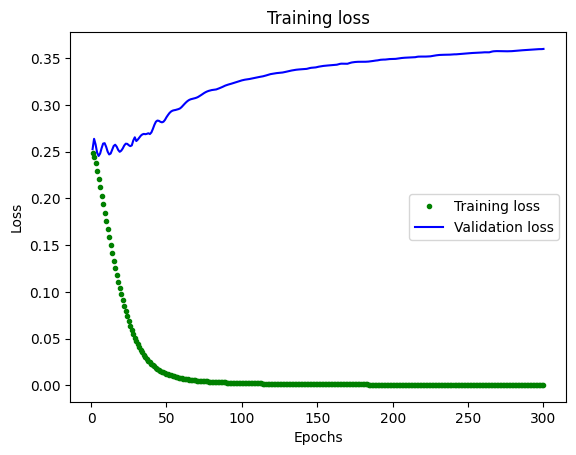

[6.4, 4.8]


In [115]:
# increase the size of the graphs. The default size is (6,4).
#plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

In [116]:
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs

print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data


1/1 [==============================] - 0s 48ms/step
predictions =
 [[0.009 0.991]
 [0.979 0.021]
 [0.983 0.017]
 [0.973 0.027]]
actual =
 [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [117]:

test_loss, test_acc = model.evaluate(inputs_test, outputs_test)

model.summary()

1/1 [==============================] - 0s 18ms/step - loss: 3.8751e-04 - accuracy: 1.0000
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_121 (Dense)           (None, 10)                5010      
                                                                 
 dense_122 (Dense)           (None, 5)                 55        
                                                                 
 dense_123 (Dense)           (None, 2)                 12        
                                                                 
Total params: 5,077
Trainable params: 5,077
Non-trainable params: 0
_________________________________________________________________


In [118]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Model is 22484 bytes


In [119]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 138,686 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
